<a href="https://colab.research.google.com/github/Abhiroop25902/Mini-Project/blob/NMS-Ananlysis/Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Setup**

In [63]:
# !gdown --id 1-N8aXiUxnB2dOpeDIU9y0wJP2ioLjKtl --output cv2.cpython-36m-x86_64-linux-gnu.so #enable GPU support

# !gdown --id 1kNtqkI2_OyzOFzP0wIzsJjD2Y6pMiXJg --output shibuya_100frames.mp4
# !gdown --id 1jgMqCnnZ5PYQxFHvJRp8W8URcQhohbJZ --output coco.names
# !gdown --id 1UuzgjSOwLJHE6FrGjluwh9ORyknlJfBw --output yolov3.cfg
# !gdown --id 1qlBKyUChyvkMc3YcSnc_4JpcxeS-93lY --output yolov3.weights


# **Importing the libraries**

In [64]:
import cv2 as cv #OpenCV Library
import numpy as np  #for handling arrays
from scipy.spatial import distance  #for cdist 
#from tqdm.std import tqdm  #for system progressbar
from tqdm.notebook import tqdm #for googl colab progressbar
import matplotlib.pyplot as plt
from IPython.display import clear_output



# **YOLO object detection function**

In [65]:
def object_detection_YOLO(img,threshold,nms_threshold):
    # determine the output layers
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    # construct a blob from the image
    # blob is just a preprocessed image
    blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)      #blob = boxes
    # blobs goes as the input to YOLO
    # inputting blob to the Neural Network
    net.setInput(blob)
    # t0 = time.time()
    outputs = net.forward(ln)   # finds output
    # t = time.time()
    # print('time=', t-t0)

    boxes = []
    confidences = []
    centroids = []
    results = []

    h, w = img.shape[:2]
    for output in outputs:  # Outputs have all the detection and their probability for every class
        for detection in output:    # detection is the the list of all probabilities with box dimension in start
            scores = detection[5:]  # everything in array after 5th element
            classID = np.argmax(scores)     # picks the maximum probability
            confidence = scores[classID] 

            if (confidence > threshold) and (classID == 0):
                #first 4 elemensts are box characteristics normalized to range(0,1)
                #first two element are middle co-ordinate
                # next two are width and height of blob           
                box = detection[:4] * np.array([w, h, w, h])    
                (centerX, centerY, width, height) = box.astype("int")   # typecasting to int, as array indexes are int
                x = int(centerX - (width / 2))      # finding upper corner
                y = int(centerY - (height / 2))
                box = [x, y, int(width), int(height)]   # changing origin to top left and typecasted to int
                boxes.append(box)                       # added the box to boxes
                confidences.append(float(confidence))   # added confidence to confidences
                centroids.append((centerX,centerY))

    indices = cv.dnn.NMSBoxes(boxes, confidences,score_threshold=threshold,nms_threshold=nms_threshold)
    # score_threshold -> threshold for confidence
    # nms_threshold -> threshold for how close to blobs are, if two blobs are too close, one of them is discarded
    # closeness is determined by IoU (intersection over Union)
    # discarding is based on confidence, higher confidence is retained

    boxes_final=[]; confidences_final=[]; centroids_final=[]
    if len(indices):
        for i in indices.flatten():
            # extract the bounding box coordinates
            x, y = (boxes[i][0], boxes[i][1])
            w, h = (boxes[i][2], boxes[i][3])
            boxes_final.append((x,y,w,h))
            confidences_final.append(confidences[i])
            centroids_final.append(centroids[i])

    return boxes_final,confidences_final,centroids_final

# **Initial setup**

In [66]:
file_name = "shibuya_100frames.mp4"

# Give the configuration and weight files for the model and load the network.
net = cv.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')  # Reads Network from .cfg and .weights
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)   # this specifies what type of hardware to use (GPU or CPU)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)     # sets preferable hardware

# **Performance Calculator**

In [67]:
def performance_ratio(object_threshold,nms_threshold,file_name):
    cap = cv.VideoCapture(file_name)
    fourcc = cv.VideoWriter_fourcc(*'mp4v')
    bad_frames = 0

    for i in tqdm(range(100)):
        ret,img = cap.read()
        if not ret: break

        boxes,confidences,centroids=object_detection_YOLO(img, object_threshold, nms_threshold)
        # box -> x,y,w,h
        # confidence -> confidence of the detected object
        # centroid -> center of the bbox, 2 values list 

        if len(boxes) > 0:
            for box in boxes:
                if box[2]*box[3] > 1280*720/2: #w*h, the size of detection box
                    bad_frames = bad_frames +1
                    break

    cap.release()
    return float(bad_frames)/100




# **Main**

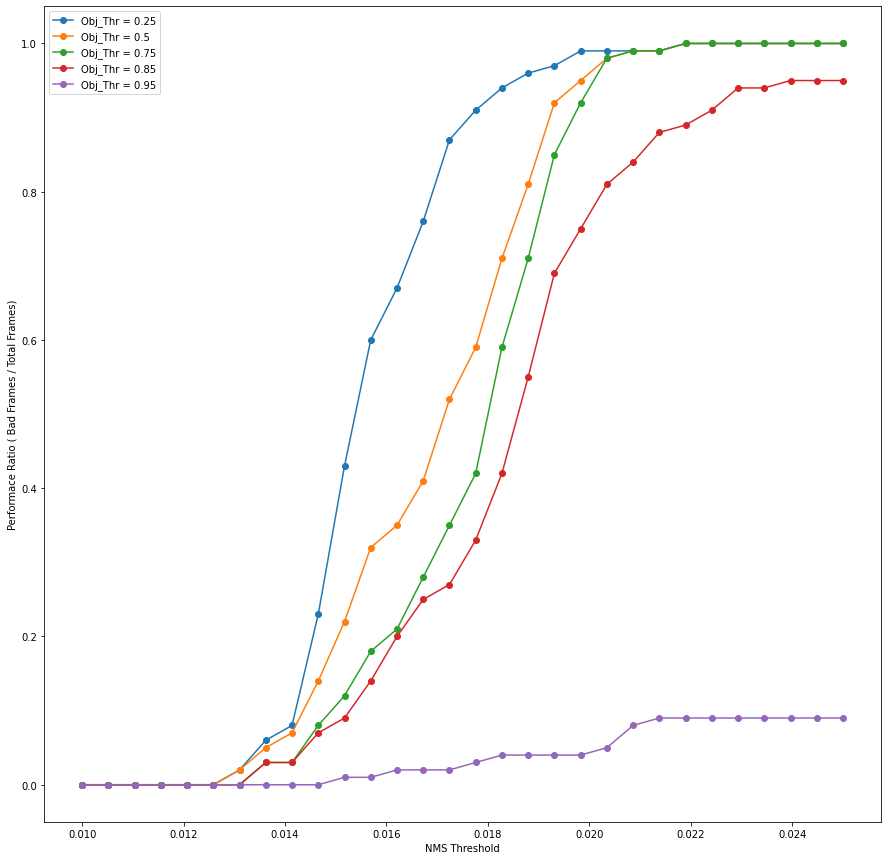

In [68]:
file_name = "shibuya_100frames.mp4"

object_thresholds = [0.25,0.5,0.75,0.85,0.95]
nms_thresholds = np.linspace(0.01,0.025, 30)

plt.figure("NMS vs Performance",figsize=(15,15))
plt.xlabel("NMS Threshold")
plt.ylabel("Performace Ratio ( Bad Frames / Total Frames)")
value = 1

for object_threshold in object_thresholds:
    performance_ratios = []
    for nms_threshold in nms_thresholds:
        clear_output()
        print(f"{value}/{5*30}")
        performance_ratios.append(performance_ratio(object_threshold,nms_threshold,file_name))
        value = value+1
    plt.plot(nms_thresholds,performance_ratios,linestyle = '-',marker = 'o',label = f"Obj_Thr = {object_threshold}")

plt.legend(loc = "best")
plt.savefig("NMS vs Performance")
plt.show()
